In [365]:
%load_ext autoreload
%autoreload 2
import gym
from gym import spaces
import numpy as np
from gym_examples.envs.dubins_car import TwoPlayerDubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [366]:
%%capture
#generate data
env = TwoPlayerDubinsCarEnv()

state = env.reset()
X = []
y = []
for i in range(50000):
    for player in env.players:
        state = env.reset()
        action = env.action_space[player].sample() 
        X.append(np.hstack([state['attacker'], state['defender']]))
        r = env.sample(state, action, player,0.5)
        y.append(r)

X = np.array(X)
y = np.array(y)

print(X[:5])
print(y[:5])


In [367]:
X

array([[-0.06295936, -4.9920397 ,  0.82629704, -1.4037526 , -0.8606496 ,
         3.0140536 ],
       [ 1.3783994 , -0.25618958, -1.9828562 ,  3.415924  , -1.7749299 ,
        -0.85586023],
       [ 3.4619508 ,  0.4624093 ,  0.11200052, -0.19847316, -2.6979709 ,
         1.5208918 ],
       ...,
       [ 3.109466  , -0.5084728 , -0.6052639 ,  4.1461368 ,  3.4597669 ,
        -0.60796845],
       [ 1.9715598 ,  0.28866976, -0.05852319, -2.6311913 , -2.3102465 ,
        -2.3737078 ],
       [ 4.9034715 , -0.08045944,  1.4215128 ,  4.873436  , -0.38292572,
        -0.9374602 ]], dtype=float32)

In [368]:
#X_train = (X - X.mean())/(X.std())


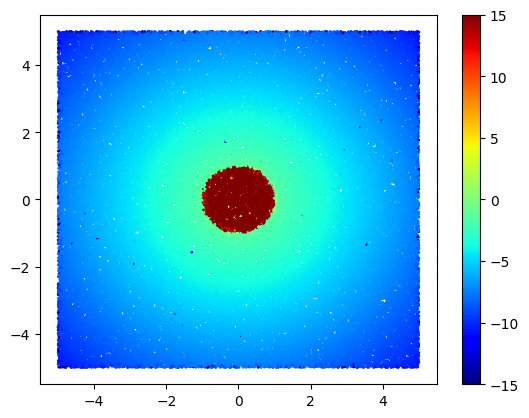

In [369]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Plot...
plt.scatter(X[:,0], X[:,1], c=y, s=1) # s is a size of marker 
plt.jet()
plt.colorbar()
plt.show()

In [370]:
print(len(X))
print(len(y))

100000
100000


In [ ]:
X

In [419]:
#params are defined *implicitly* in haiku
# def forward(X):
#     l1 = hk.Linear(12)(X)
#     l2 = jax.nn.relu(l1)
#     l3 = hk.Linear(6)(l2)
#     l4 = jax.nn.relu(l3)

#     l5= hk.Linear(1)(l4)

#     return l5

#params are defined *implicitly* in haiku
def forward(X):
    l1 = hk.Linear(18)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(1)(l2)

    return l3.ravel()


# def forward(X):

#     mlp = hk.nets.MLP(output_sizes=[3,1])
#     return mlp(X)

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = forward.apply


def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse





optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(params)
batch_size = 100

# for epoch in range(3000):
#     loss, grads = jax.value_and_grad(loss_fn)(params,X=X,y=y)
#     print("progress:", "epoch:", epoch, "loss",loss)
#     updates, opt_state = optimizer.update(grads, opt_state, params)
#     params = optax.apply_updates(params, updates)

for epoch in range(10):
    for batch in range(0,len(X), batch_size):
        loss, grads = jax.value_and_grad(loss_fn)(params,X=X[batch:batch+batch_size],y=y[batch:batch+batch_size])
        print("progress:", "epoch:", epoch, "loss",loss)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        
    
# After training
print("estimation of the parameters:")
print(params)



progress: epoch: 0 loss 43.230003
progress: epoch: 0 loss 52.87912
progress: epoch: 0 loss 51.93303
progress: epoch: 0 loss 45.25025
progress: epoch: 0 loss 48.33071
progress: epoch: 0 loss 45.49219
progress: epoch: 0 loss 47.983475
progress: epoch: 0 loss 45.157352
progress: epoch: 0 loss 44.840965
progress: epoch: 0 loss 43.512978
progress: epoch: 0 loss 46.06767
progress: epoch: 0 loss 53.88857
progress: epoch: 0 loss 47.45324
progress: epoch: 0 loss 46.597923
progress: epoch: 0 loss 48.480537
progress: epoch: 0 loss 47.01917
progress: epoch: 0 loss 44.10446
progress: epoch: 0 loss 47.896317
progress: epoch: 0 loss 45.358906
progress: epoch: 0 loss 44.929913
progress: epoch: 0 loss 47.7171
progress: epoch: 0 loss 37.621326
progress: epoch: 0 loss 43.471836
progress: epoch: 0 loss 47.442642
progress: epoch: 0 loss 45.472202
progress: epoch: 0 loss 33.882816
progress: epoch: 0 loss 38.736473
progress: epoch: 0 loss 49.15222
progress: epoch: 0 loss 46.0382
progress: epoch: 0 loss 46.42

In [413]:
test_state = env.reset()
input = np.hstack([test_state['attacker'], test_state['defender']])
estimate  = forward(X=input, params=params)
print("estimate", estimate)

reset {'attacker': array([-1.0783764, -0.5493257, -2.1650183], dtype=float32), 'defender': array([0.40108287, 0.15410182, 0.2707248 ], dtype=float32)}
estimate [2.3496013]


In [424]:
env = TwoPlayerDubinsCarEnv()
state = env.reset()
done = False
max_iter = 100
counter = 0
print(env.car_position)
while (not done) and (counter < max_iter):
    counter+=1
    possible_actions = []
    for d_action in range(env.action_space['defender'].n):
        state_ , reward, done, info = env.state_action_step(state, d_action, 'defender')
        defender_actions = []
        for a_action in range(env.action_space['attacker'].n):
            next_state, reward, _, _ = env.state_action_step(state_, a_action, 'attacker')
            input = np.hstack([next_state['attacker'], next_state['defender']])
            estimate  = forward(X=input, params=params)
            print('estimate', estimate, 'actual', reward)
            possible_actions.append([d_action, a_action, estimate[0]])
        pa = np.array(possible_actions)
        cand_attack_actions = np.argmax(pa.T,axis=0)
        best_defender_action =  np.argmin(np.max(pa.T,axis=0))
        best_attacker_action = cand_attack_actions[best_defender_action]
        print(counter)




        state, reward, done, _ = env.step(best_defender_action, 'defender')
        state, reward, done, _ = env.step(best_attacker_action, 'attacker')

        env.render()
    
env.make_gif()

reset {'attacker': array([-3.2174432,  1.3056425,  2.113773 ], dtype=float32), 'defender': array([-0.21977432, -3.2752664 , -1.7507133 ], dtype=float32)}
{'attacker': array([-3.2174432,  1.3056425,  2.113773 ], dtype=float32), 'defender': array([-0.21977432, -3.2752664 , -1.7507133 ], dtype=float32)}
estimate [-4.9062376] actual -3.50171913334472
estimate [-4.971993] actual -3.5313779957346143
estimate [-5.0469065] actual -3.563848657801711
1
estimate [-5.166471] actual -3.621215277521528
estimate [-5.225484] actual -3.64878155252657
estimate [-5.2943783] actual -3.6794222081329186
1
estimate [-5.398222] actual -3.7325200590981154
estimate [-5.449849] actual -3.757881722037966
estimate [-5.5120015] actual -3.7865590039532044
1
estimate [-5.6034017] actual -3.835175777319987
estimate [-5.6470675] actual -3.8582335197828375
estimate [-5.7018347] actual -3.884827188128359
2
estimate [-5.775133] actual -3.9287755109985185
estimate [-5.810366] actual -3.9494425764678747
estimate [-5.857174]

In [376]:
possible_actions

[[0, 0, Array(-8.403739, dtype=float32)],
 [0, 1, Array(-8.453172, dtype=float32)],
 [0, 2, Array(-8.489318, dtype=float32)],
 [1, 0, Array(-8.607101, dtype=float32)],
 [1, 1, Array(-8.6649275, dtype=float32)],
 [1, 2, Array(-8.710007, dtype=float32)],
 [2, 0, Array(-8.8417635, dtype=float32)],
 [2, 1, Array(-8.907352, dtype=float32)],
 [2, 2, Array(-8.960833, dtype=float32)]]

In [ ]:
import pandas as pd
df = pd.DataFrame(possible_actions, columns=['defender', 'attacker','value'])
df


In [ ]:
pa = np.array(possible_actions)
pa = pa[:,2].reshape(3,3)
pa

In [ ]:
best_attacker_moves = np.argmax(pa.T,axis=0)

best_defender_move =  np.argmin(np.max(pa.T,axis=0))

best_attacker_move = best_attacker_moves[best_defender_move]
print(best_defender_move,best_attacker_move)


In [ ]:
pa.T[best_attacker_moves]

In [ ]:
possible_actions